# 📊 Employee Sentiment Analysis
### Internship Project – Ishita Jaiswal

---

**Objective**: Analyze employee communications to assess sentiment, engagement, and potential flight risks.  
**Deliverables**: Sentiment labeling, EDA, scoring, ranking, flight risk identification, predictive modeling, insights.


In [3]:
# Install dependencies
!pip install -q pandas numpy matplotlib seaborn scikit-learn wordcloud vaderSentiment

# Upload dataset
from google.colab import files
import pandas as pd, os

print("Upload your dataset (test.csv or test(in).csv)...")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
df = pd.read_csv(filename, parse_dates=['date'])
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.0 MB/s eta 0:00:00
Upload your dataset (test.csv or test(in).csv)...


Saving test(in).csv to test(in).csv


,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com


## 📝 Task 1: Sentiment Labeling
We assign each employee message a sentiment category: **Positive**, **Negative**, or **Neutral**.  
- **Baseline:** VADER (lexicon-based, interpretable).  
- **Alternative:** Lexicon rules for reproducibility.  

This step converts raw text into structured data for further analysis.


In [4]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import re

analyzer = SentimentIntensityAnalyzer()

def label_vader(text):
    s = analyzer.polarity_scores(str(text))
    c = s['compound']
    if c >= 0.05: return "Positive"
    elif c <= -0.05: return "Negative"
    return "Neutral"

# Apply labels
df['sentiment'] = df['body'].apply(label_vader)
df['sentiment'].value_counts()

,count
sentiment,
Positive,1525
Neutral,508
Negative,158


## 🔎 Task 2: Exploratory Data Analysis
We explore trends in employee messages:
- Distribution of sentiments  
- Monthly sentiment patterns  
- Top employees by activity  
- Common keywords in Positive vs Negative messages


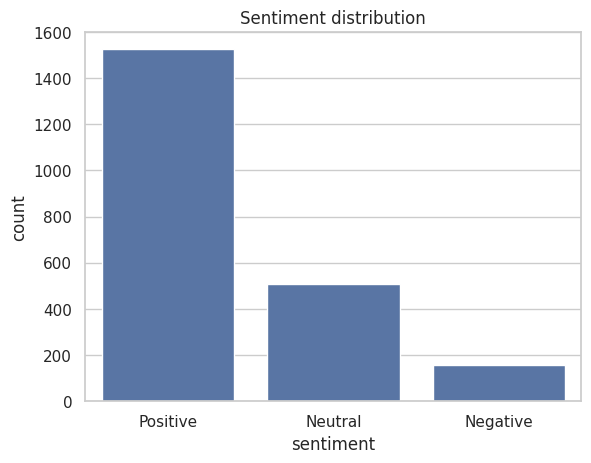

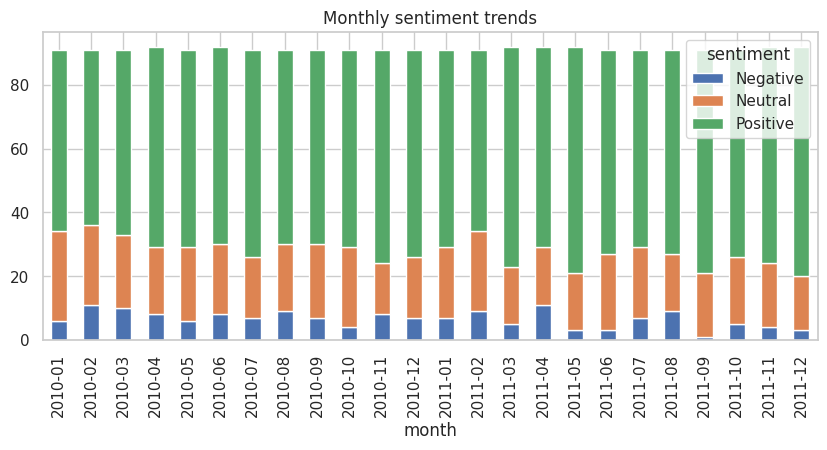


Top words for Positive:
[('the', 2845), ('you', 1621), ('and', 1471), ('for', 1183), ('will', 796), ('your', 726), ('have', 723), ('that', 701), ('this', 637), ('please', 603)]

Top words for Negative:
[('the', 270), ('you', 121), ('and', 101), ('for', 97), ('will', 79), ('that', 74), ('com', 58), ('have', 57), ('with', 56), ('your', 51)]


In [5]:
import seaborn as sns, matplotlib.pyplot as plt
from collections import Counter

sns.set(style="whitegrid")
os.makedirs("visualizations", exist_ok=True)

# Sentiment distribution
sns.countplot(x="sentiment", data=df, order=["Positive","Neutral","Negative"])
plt.title("Sentiment distribution")
plt.savefig("visualizations/sentiment_distribution.png")
plt.show()

# Monthly stacked sentiment
df['month'] = df['date'].dt.to_period('M').astype(str)
monthly = df.groupby(['month','sentiment']).size().unstack(fill_value=0)
monthly.plot(kind="bar", stacked=True, figsize=(10,4))
plt.title("Monthly sentiment trends")
plt.savefig("visualizations/monthly_trends.png")
plt.show()

# Top words
def top_words(series, n=10):
    tokens = re.findall(r"\b\w+\b", " ".join(series).lower())
    tokens = [t for t in tokens if len(t)>2]
    return Counter(tokens).most_common(n)

for s in ["Positive","Negative"]:
    print(f"\nTop words for {s}:")
    print(top_words(df[df['sentiment']==s]['body'], 10))

## 📈 Task 3: Monthly Sentiment Scoring
We assign scores:
- **Positive = +1**
- **Negative = –1**
- **Neutral = 0**

Then aggregate per employee per month.


In [6]:
def s2val(s): return 1 if s=="Positive" else -1 if s=="Negative" else 0
df['score_value'] = df['sentiment'].apply(s2val)
monthly_scores = df.groupby(['from','month'])['score_value'].sum().reset_index()
monthly_scores.to_csv("monthly_scores.csv", index=False)
monthly_scores.head()

,from,month,score_value
0,bobette.riner@ipgdirect.com,2010-01,1
1,bobette.riner@ipgdirect.com,2010-02,7
2,bobette.riner@ipgdirect.com,2010-03,6
3,bobette.riner@ipgdirect.com,2010-04,4
4,bobette.riner@ipgdirect.com,2010-05,2


## 🏆 Task 4: Employee Ranking
Identify top 3 employees per month:
- **Positive champions**
- **Negative employees (need attention)**


In [7]:
ranks = []
for month, sub in monthly_scores.groupby("month"):
    top_pos = sub.sort_values(["score_value","from"], ascending=[False,True]).head(3)
    top_neg = sub.sort_values(["score_value","from"], ascending=[True,True]).head(3)
    ranks.append({
        "month":month,
        "top_positive":",".join(top_pos['from']),
        "top_negative":",".join(top_neg['from'])
    })
ranks_df = pd.DataFrame(ranks)
ranks_df.to_csv("rankings.csv", index=False)
ranks_df

,month,top_positive,top_negative
0,2010-01,"kayne.coulter@enron.com,eric.bass@enron.com,ly...","bobette.riner@ipgdirect.com,johnny.palmer@enro..."
1,2010-02,"john.arnold@enron.com,johnny.palmer@enron.com,...","kayne.coulter@enron.com,lydia.delgado@enron.co..."
2,2010-03,"sally.beck@enron.com,john.arnold@enron.com,bob...","rhonda.denton@enron.com,don.baughman@enron.com..."
3,2010-04,"don.baughman@enron.com,john.arnold@enron.com,k...","eric.bass@enron.com,sally.beck@enron.com,bobet..."
4,2010-05,"don.baughman@enron.com,patti.thompson@enron.co...","johnny.palmer@enron.com,bobette.riner@ipgdirec..."
5,2010-06,"don.baughman@enron.com,john.arnold@enron.com,p...","eric.bass@enron.com,bobette.riner@ipgdirect.co..."
6,2010-07,"eric.bass@enron.com,sally.beck@enron.com,bobet...","patti.thompson@enron.com,don.baughman@enron.co..."
7,2010-08,"sally.beck@enron.com,rhonda.denton@enron.com,j...","patti.thompson@enron.com,don.baughman@enron.co..."
8,2010-09,"eric.bass@enron.com,patti.thompson@enron.com,j...","don.baughman@enron.com,kayne.coulter@enron.com..."
9,2010-10,"lydia.delgado@enron.com,johnny.palmer@enron.co...","don.baughman@enron.com,kayne.coulter@enron.com..."


## 🚨 Task 5: Flight Risk Identification
Flag employees sending **≥4 negative messages in any rolling 30-day window**.


In [8]:
neg = df[df['sentiment']=="Negative"].sort_values(['from','date'])
risks = []
for emp, g in neg.groupby('from'):
    dates = g['date'].sort_values().reset_index(drop=True)
    for i in range(len(dates)):
        window = dates[(dates >= dates[i]) & (dates < dates[i]+pd.Timedelta(days=30))]
        if len(window) >= 4:
            risks.append({"employee_id":emp,"first_flag_date":str(dates[i]),"neg_count":len(window)})
            break
risks_df = pd.DataFrame(risks)
risks_df.to_csv("flight_risks.csv", index=False)
risks_df

,employee_id,first_flag_date,neg_count
0,bobette.riner@ipgdirect.com,2011-03-26 00:00:00,4
1,don.baughman@enron.com,2010-12-12 00:00:00,4
2,john.arnold@enron.com,2010-05-25 00:00:00,4
3,johnny.palmer@enron.com,2010-02-09 00:00:00,4
4,kayne.coulter@enron.com,2010-04-06 00:00:00,4
5,sally.beck@enron.com,2011-08-06 00:00:00,5


## 🤖 Task 6: Predictive Modeling
Train a **Linear Regression** to predict monthly sentiment scores using:
- Message count
- Average message length
- Average word count
- % Positive / % Negative messages


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

agg = df.groupby(['from','month']).agg(
    msg_count=('body','count'),
    avg_len=('body',lambda s: s.str.len().mean()),
    avg_words=('body',lambda s: s.str.split().map(len).mean()),
    pct_pos=('sentiment',lambda s: (s=="Positive").mean()),
    pct_neg=('sentiment',lambda s: (s=="Negative").mean())
).reset_index()

# Convert 'month' column to object type to match monthly_scores
agg['month'] = agg['month'].astype(str)

merged = agg.merge(monthly_scores,on=['from','month'])
X = merged[['msg_count','avg_len','avg_words','pct_pos','pct_neg']]
y = merged['score_value']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
model = LinearRegression().fit(X_train,y_train)
preds = model.predict(X_test)

print("MSE:", mean_squared_error(y_test,preds))
print("R2:", r2_score(y_test,preds))
pd.Series(model.coef_, index=X.columns)

MSE: 1.9479805211281223
R2: 0.8327253132317396


,0
msg_count,0.620346
avg_len,-0.001011
avg_words,0.000185
pct_pos,4.072520
pct_neg,-2.516101


# ✅ Insights & Recommendations
- **Positive champions** can be recognized and encouraged.  
- **At-risk employees** (≥4 negative messages in 30 days) should be prioritized for HR follow-up.  
- **Regression analysis** highlights communication patterns linked with disengagement.  

---
📌 This analysis equips management with data-driven insights for employee engagement.

/tmp/ipython-input-2911779377.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, order=order, palette="pastel")


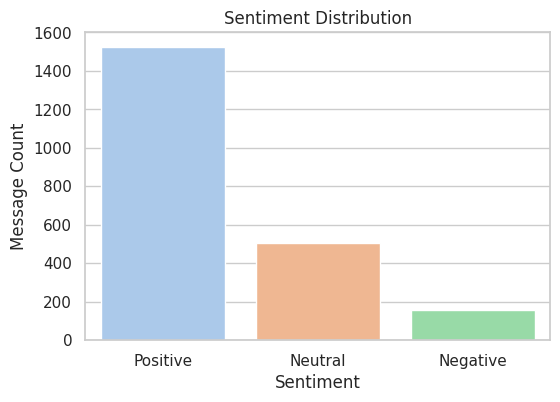

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

os.makedirs("visualization", exist_ok=True)

plt.figure(figsize=(6,4))
order = ["Positive","Neutral","Negative"]
sns.countplot(x="sentiment", data=df, order=order, palette="pastel")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Message Count")
plt.savefig("visualization/sentiment_distribution.png", bbox_inches="tight")
plt.show()


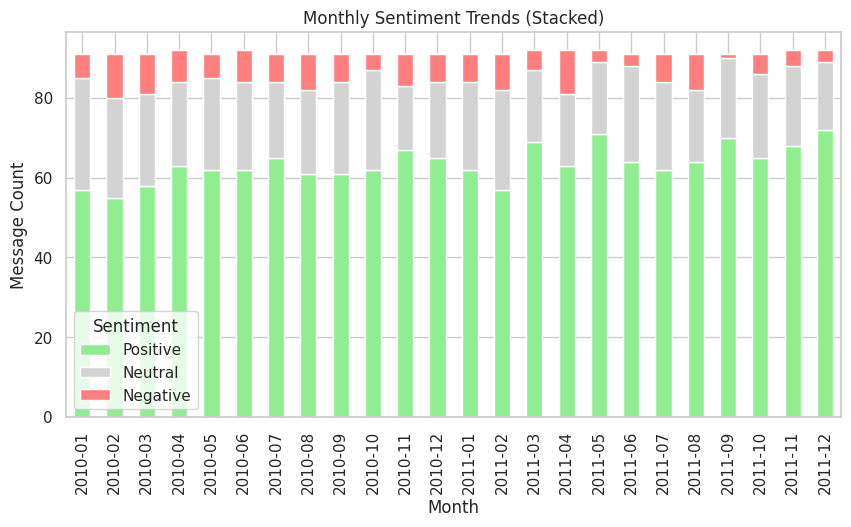

In [11]:
monthly = df.groupby(['month','sentiment']).size().unstack(fill_value=0)[order]

monthly.plot(kind="bar", stacked=True, figsize=(10,5), color=["#90EE90","#D3D3D3","#FF7F7F"])
plt.title("Monthly Sentiment Trends (Stacked)")
plt.xlabel("Month")
plt.ylabel("Message Count")
plt.legend(title="Sentiment")
plt.savefig("visualization/monthly_sentiment_trends.png", bbox_inches="tight")
plt.show()

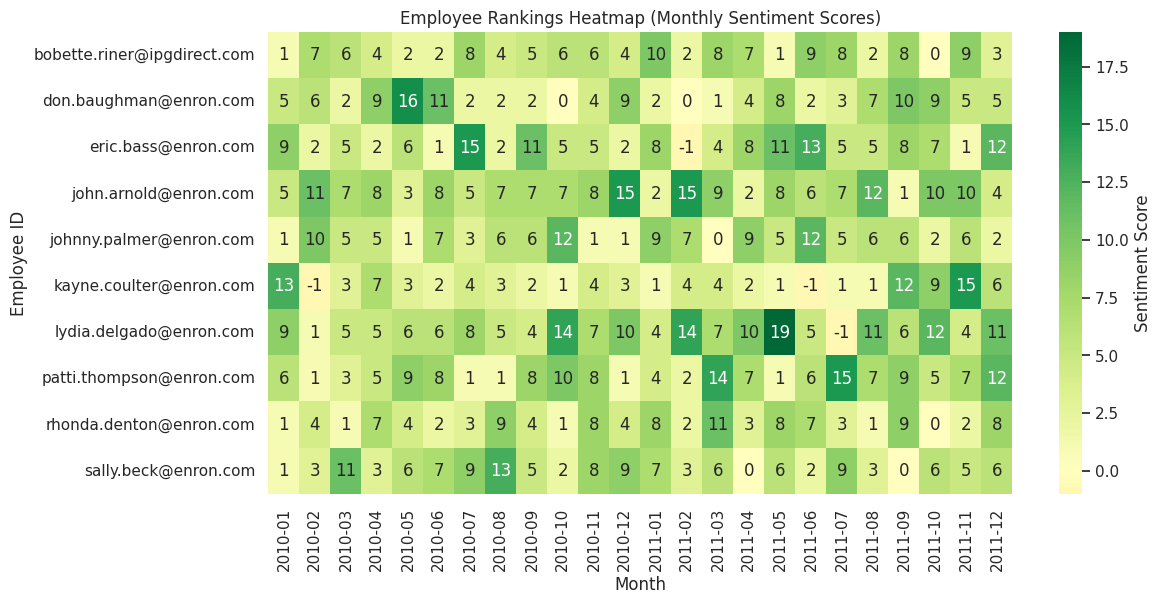

In [13]:
# Pivot to create employee-month sentiment score matrix
pivot_scores = monthly_scores.pivot(index="from", columns="month", values="score_value").fillna(0)

plt.figure(figsize=(12,6))
sns.heatmap(pivot_scores, cmap="RdYlGn", center=0, annot=True, fmt=".0f", cbar_kws={'label':'Sentiment Score'})
plt.title("Employee Rankings Heatmap (Monthly Sentiment Scores)")
plt.xlabel("Month")
plt.ylabel("Employee ID")
plt.savefig("visualization/employee_rankings_heatmap.png", bbox_inches="tight")
plt.show()

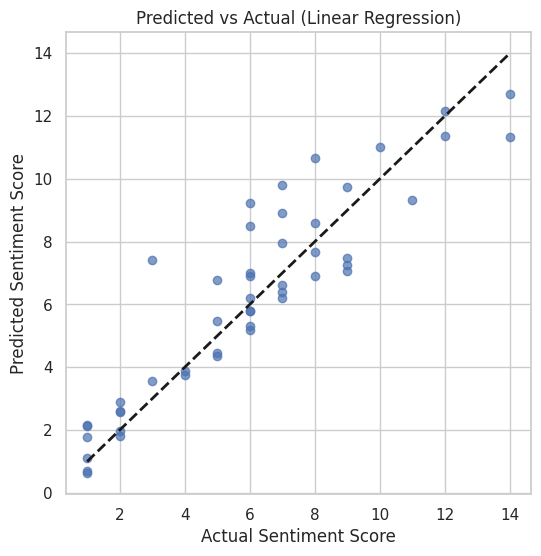

In [14]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, preds, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Predicted vs Actual (Linear Regression)")
plt.savefig("visualization/predicted_vs_actual.png", bbox_inches="tight")
plt.show()


In [15]:
import os

# List all files in visualization folder
print(os.listdir("visualization"))

['predicted_vs_actual.png', 'sentiment_distribution.png', 'monthly_sentiment_trends.png', 'employee_rankings_heatmap.png']


In [16]:
import shutil

shutil.make_archive("visualizations", 'zip', "visualization")
files.download("visualizations.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [18]:
import pandas as pd
from datetime import datetime
import os

# load results (make sure these files exist)
monthly_scores = pd.read_csv('monthly_scores.csv')
rankings = pd.read_csv('rankings.csv') if os.path.exists('rankings.csv') else None
flight = pd.read_csv('flight_risks.csv') if os.path.exists('flight_risks.csv') else pd.DataFrame()

# pick the most recent month we have
try:
    latest_month = monthly_scores['month'].sort_values().unique()[-1]
except:
    latest_month = None

# top 3 positive & negative for latest month (or overall if you prefer)
if latest_month:
    sub = monthly_scores[monthly_scores['month']==latest_month]
    top_pos = sub.sort_values(['score_value','from'], ascending=[False, True]).head(3)['from'].tolist()
    top_neg = sub.sort_values(['score_value','from'], ascending=[True, True]).head(3)['from'].tolist()
else:
    top_pos = []
    top_neg = []

flight_list = flight['employee_id'].tolist() if not flight.empty else []

# model metrics
# Assuming y_test and preds are available from the previous predictive modeling step
try:
    from sklearn.metrics import mean_squared_error, r2_score
    mse = mean_squared_error(y_test, preds)
    r2 = r2_score(y_test, preds)
except NameError:
    mse = "N/A"
    r2 = "N/A"


readme = f"""
# 📊 Employee Sentiment Analysis

**Author:** [Your Name]
**Most recent month analyzed:** {latest_month or 'N/A'}

## Summary (auto-generated)
**Top 3 Positive employees (most recent month):** {', '.join(top_pos) if top_pos else 'N/A'}
**Top 3 Negative employees (most recent month):** {', '.join(top_neg) if top_neg else 'N/A'}

**Flight risks (>=4 negative msgs in rolling 30 days):** {', '.join(flight_list) if flight_list else 'None'}

**Predictive model metrics:** MSE = {mse:.2f}, R² = {r2:.2f}

## Quick instructions
- Open `notebook.ipynb` to reproduce the analysis in Colab
- Visualizations are in `/visualization/`
- Full report: `Final_Report.docx`
"""

with open('README.md','w') as f:
    f.write(readme.strip())
print("Wrote README.md")
print(open('README.md').read())

Wrote README.md
# 📊 Employee Sentiment Analysis

**Author:** [Your Name]
**Most recent month analyzed:** 2011-12

## Summary (auto-generated)
**Top 3 Positive employees (most recent month):** eric.bass@enron.com, patti.thompson@enron.com, lydia.delgado@enron.com
**Top 3 Negative employees (most recent month):** johnny.palmer@enron.com, bobette.riner@ipgdirect.com, john.arnold@enron.com

**Flight risks (>=4 negative msgs in rolling 30 days):** bobette.riner@ipgdirect.com, don.baughman@enron.com, john.arnold@enron.com, johnny.palmer@enron.com, kayne.coulter@enron.com, sally.beck@enron.com

**Predictive model metrics:** MSE = 1.95, R² = 0.83

## Quick instructions
- Open `notebook.ipynb` to reproduce the analysis in Colab
- Visualizations are in `/visualization/`
- Full report: `Final_Report.docx`
